# Note 01: Finding Principal Components for a three factor Libor Market Model 

In a previous work on the Libor Market Model, we set up a three-factor model where forward rates were not perfectly correlated across maturities via using three principal component factors. The data was taken from, Fixed Income Securities, Pietro Veronesi, and included both the volatility of forward rates, which was estimated by taking the standard deviation of the change in the log of forward rates, as well as the principal components of the change in the log of forward rates, "the 3 Principal Component Factors".

We did not explain how the principal component factors were calculated. In this workbook, we want to do just that.

Our data was collected from https://www.quantandfinancial.com/2016/11/hjm.htm. 
It is an excellent source of financial data, analytics and strategies, in https://www.quantandfinancial.com/

### Load libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg as la
%matplotlib inline

### Read our data set

In [2]:
dataframe    = pd.DataFrame.from_csv('FwdData.csv')
dataframe    = dataframe / 100.0 
dataframelog = np.log(dataframe)
print (dataframe.shape)
# there are 39 forward tenors, spanning 1264 trading days. 

(1264, 39)


C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  """Entry point for launching an IPython kernel.


In [3]:
dataframe.head()

,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,...,15.5,16,16.5,17,17.5,18,18.5,19,19.5,20
Tenor,,,,,,,,,,,,,,,,,,,,,
1,0.067142,0.066512,0.064991,0.063255,0.061534,0.059925,0.058444,0.057058,0.055723,0.054393,...,0.031268,0.031181,0.031213,0.031348,0.031572,0.031870,0.032234,0.032656,0.033128,0.033643
2,0.067502,0.066842,0.065423,0.063852,0.062301,0.060846,0.059490,0.058198,0.056924,0.055623,...,0.030577,0.030473,0.030501,0.030644,0.030886,0.031212,0.031613,0.032079,0.032603,0.033176
3,0.067354,0.066845,0.065577,0.064109,0.062611,0.061164,0.059782,0.058438,0.057097,0.055722,...,0.030088,0.029929,0.029899,0.029982,0.030164,0.030429,0.030769,0.031174,0.031638,0.032151
4,0.066942,0.066215,0.064904,0.063462,0.062006,0.060601,0.059252,0.057933,0.056608,0.055242,...,0.029232,0.029004,0.028904,0.028921,0.029039,0.029247,0.029535,0.029895,0.030319,0.030799
5,0.066358,0.065502,0.064168,0.062722,0.061262,0.059849,0.058488,0.057157,0.055820,0.054448,...,0.028450,0.028167,0.028011,0.027973,0.028039,0.028200,0.028447,0.028770,0.029162,0.029615


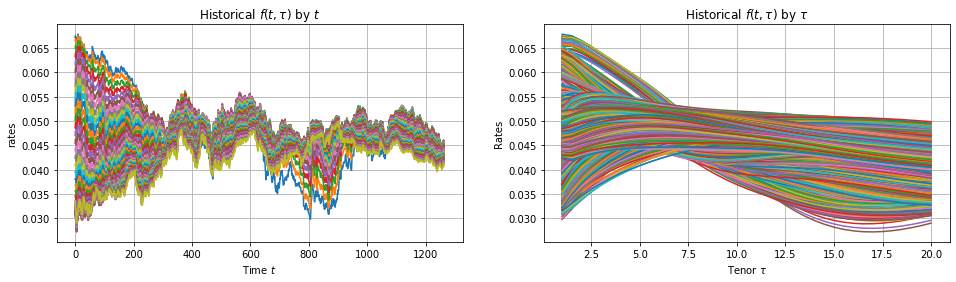

In [4]:
tenors        = [float(x) for x in dataframe.columns]
hist_rates    = np.matrix(dataframe)

plt.figure(figsize=(16,4))
plt.subplot(121)
plt.plot(hist_rates)
plt.xlabel(r'Time $t$ ')
plt.title(r'Historical $f(t,\tau)$ by $t$')
plt.grid(True)
plt.ylabel('rates')

plt.subplot(122)
plt.plot(tenors, hist_rates.transpose())
plt.xlabel(r'Tenor $\tau$') 
plt.title(r'Historical $f(t,\tau)$ by $\tau$')
plt.grid(True)
plt.ylabel('Rates')
plt.show()

### Calculate the daily differences for the various tenor log forward rates $dln(f(t,\tau))$

In [5]:
hist_rates_log = np.matrix(dataframelog)
diff_rates_log = np.diff(hist_rates_log, axis=0)
print("Data set shape : " + str(diff_rates_log.shape))

Data set shape : (1263, 39)


### Calculate the historical volatility of the changes in the log of forward rates (daily and annualized)
volatility as the standard deviation of $dln(f(t,\tau))$

In [6]:
std_of_log_Diff  = diff_rates_log.std(axis=0)
size             = diff_rates_log.std(axis=0).shape[1]
sdslog           = np.zeros(size)

for i in range(0,size):
    sdslog[i] = std_of_log_Diff[0,i]

In [7]:
vols_hist = pd.DataFrame({'Tenors': tenors, 'Hist_Daily_Vol': sdslog, 'Hist_Annual_Vol': sdslog*np.sqrt(252)}, \
                         columns=['Tenors', 'Hist_Daily_Vol','Hist_Annual_Vol'])

print (vols_hist.head())

   Tenors  Hist_Daily_Vol  Hist_Annual_Vol
0     1.0        0.013060         0.207320
1     1.5        0.012621         0.200355
2     2.0        0.011530         0.183029
3     2.5        0.010619         0.168569
4     3.0        0.010074         0.159917


### Principal component analysis
Extract principal components from the $dln(f(t,\tau))$

#### Calculate covariance matrix

In [8]:
sigma = np.cov(diff_rates_log.transpose())
print("Sigma shape : " + str(sigma.shape))

Sigma shape : (39, 39)


#### Calculate eigenvalues and eigenvectors

In [9]:
evals, evecs = la.eig(sigma)
evecs = np.matrix(evecs)

# check the shapes
print("eigval shape : " + str(evals.shape))
print("eigvec shape : " + str(evecs.shape))

eigval shape : (39,)
eigvec shape : (39, 39)


#### Determine the largest three principal components

In [10]:
# These are the steps:
# 1 - We collect the THREE positions in the eigenvalue arrays, where we find the largest eigenvalues
# 2 - We collect the corresponding THREE eigenvectors, those with the the THREE largest eigenvalues
# 3 - We call the THREE eigenvectors "princ_comp"

factors = 3
index_evecs = list(reversed(np.real(evals).argsort()))[0:factors]
princ_evals = np.array([evals[i] for i in index_evecs])
princ_comp  = np.hstack([evecs[:,i] for i in index_evecs])

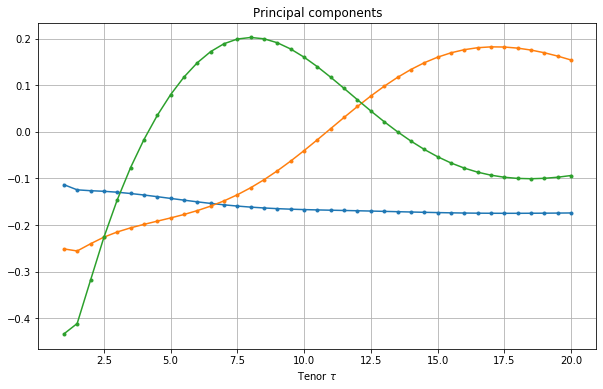

In [11]:
plt.figure(figsize=(10,6))
plt.plot(tenors, princ_comp, marker='.'), plt.title('Principal components'), plt.xlabel(r'Tenor $\tau$');
plt.grid(True)
plt.show()

### Calculate the Daily Volatility Factors: 1, 2 and 3
First we take the square root of the three largest eigenvalues and then we multiply them by the largest three principal components

In [12]:
sqrt_evals = np.matrix(np.real(princ_evals) ** .5)
tmp_m      = np.vstack([sqrt_evals for i in range(princ_comp.shape[0])]) 
daily_vols = np.multiply(np.real(tmp_m), np.real(princ_comp)) 
print('daily vols shape: ' + str(daily_vols.shape))

daily vols shape: (39, 3)


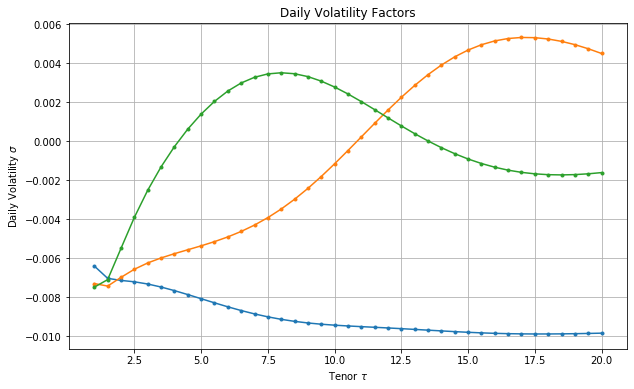

In [13]:
plt.figure(figsize=(10,6))
plt.plot(tenors, daily_vols, marker='.'), plt.title('Daily Volatility Factors'), plt.xlabel(r'Tenor $\tau$'), \
plt.ylabel(r'Daily Volatility $\sigma$');
plt.grid(True)
plt.show()

In [14]:
vols_hist['Factor_1_Daily'] = daily_vols[:,0]
vols_hist['Factor_2_Daily'] = daily_vols[:,1]
vols_hist['Factor_3_Daily'] = daily_vols[:,2]
print (vols_hist.head())

   Tenors  Hist_Daily_Vol  Hist_Annual_Vol  Factor_1_Daily  Factor_2_Daily  \
0     1.0        0.013060         0.207320       -0.006407       -0.007306   
1     1.5        0.012621         0.200355       -0.007040       -0.007436   
2     2.0        0.011530         0.183029       -0.007145       -0.006988   
3     2.5        0.010619         0.168569       -0.007216       -0.006573   
4     3.0        0.010074         0.159917       -0.007330       -0.006250   

   Factor_3_Daily  
0       -0.007491  
1       -0.007104  
2       -0.005500  
3       -0.003913  
4       -0.002522  


### Finally we calculate the sum of the annualized volatility factors and compare it with the historical annualized volatility of the changes in the log of forward rates

In [15]:
vols_hist['PCA_Factors_Daily_Vol'] = \
np.sqrt(vols_hist['Factor_1_Daily']**2 + vols_hist['Factor_2_Daily']**2 + vols_hist['Factor_3_Daily']**2)
vols_hist['PCA_Factors_Annual_Vol'] = vols_hist['PCA_Factors_Daily_Vol']*np.sqrt(252)

In [16]:
vols_hist.head()

,Tenors,Hist_Daily_Vol,Hist_Annual_Vol,Factor_1_Daily,Factor_2_Daily,Factor_3_Daily,PCA_Factors_Daily_Vol,PCA_Factors_Annual_Vol
0,1.0,0.013060,0.207320,-0.006407,-0.007306,-0.007491,0.012270,0.194781
1,1.5,0.012621,0.200355,-0.007040,-0.007436,-0.007104,0.012463,0.197844
2,2.0,0.011530,0.183029,-0.007145,-0.006988,-0.005500,0.011407,0.181087
3,2.5,0.010619,0.168569,-0.007216,-0.006573,-0.003913,0.010516,0.166939
4,3.0,0.010074,0.159917,-0.007330,-0.006250,-0.002522,0.009957,0.158063


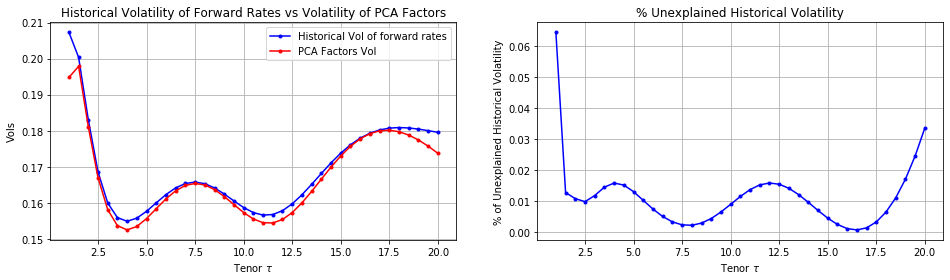

In [17]:
plt.figure(figsize=(16,4))

plt.subplot(121)
plt.plot(vols_hist.Tenors, vols_hist.Hist_Annual_Vol, lw=1.5, color='blue', label ='Historical Vol of forward rates', marker='.')
plt.plot(vols_hist.Tenors, vols_hist.PCA_Factors_Annual_Vol, lw=1.5,   color='red', label ='PCA Factors Vol', marker='.')
plt.legend()
plt.xlabel(r'Tenor $\tau$') 
plt.ylabel('Vols')
plt.grid(True)
plt.title("Historical Volatility of Forward Rates vs Volatility of PCA Factors");

plt.subplot(122)
plt.plot(vols_hist.Tenors, (vols_hist.Hist_Annual_Vol - vols_hist.PCA_Factors_Annual_Vol)/vols_hist.PCA_Factors_Annual_Vol\
         , lw=1.5, color='blue', marker='.')
plt.xlabel(r'Tenor $\tau$') 
plt.ylabel('% of Unexplained Historical Volatility')
plt.grid(True)
plt.title("% Unexplained Historical Volatility");

plt.show()